# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
import matplotlib.pyplot as plt
import helper

# Training data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### Visualize
Visualize one batch of images.

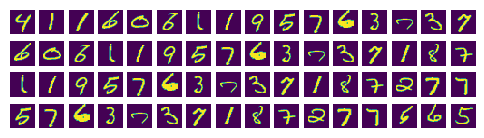

In [3]:
images, labels = next(iter(trainloader))

fig, ax = plt.subplots(4,16, dpi=100)
for irow in range(ax.shape[0]):
    for icol in range(ax.shape[1]):
        ax[irow,icol].imshow(images[(ax.shape[0]-1)*irow + icol].squeeze())
        ax[irow,icol].axis('off')
plt.subplots_adjust(hspace=-0.85)
plt.show()

# Model
Use a neural network with two hidden layers with 128 and 64 hidden units, respectively.
Input images have a shape of 28 x 28, therefore, input size = 28x28 = 784.
Output size is 10 because of 10 digits.

In [4]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
units = [input_size] + hidden_sizes + [output_size]

# Define model in pytorch
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(units[0], units[1])),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(units[1], units[2])),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(units[2], units[3])),
    ('relu3', nn.ReLU()),
    ('fc4', nn.Linear(units[3], units[4])),
    ('log-softmax', nn.LogSoftmax(dim=1))
]))
print(model)

# Use negative log-likelihood loss and SGD optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (log-softmax): LogSoftmax()
)


# Training

In [5]:
# Train for several epoch.
n_epochs = 5
for iepoch in range(n_epochs):
    cost = 0
    # Get a batch of images and train
    for images, labels in trainloader:
        # Flatten images
        images = images.view(images.shape[0],-1)        
        # Forward pass (compute output) and loss
        output = model.forward(images)
        loss = criterion(output, labels)
        # Backpropagation and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate cost for each image in the batch
        cost += loss.item()
    print('Training cost = {:0.4}'.format(cost/len(trainloader)) )

Training cost = 0.3288
Training cost = 0.1675
Training cost = 0.1324
Training cost = 0.1163
Training cost = 0.1073


# Testing

In [6]:
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

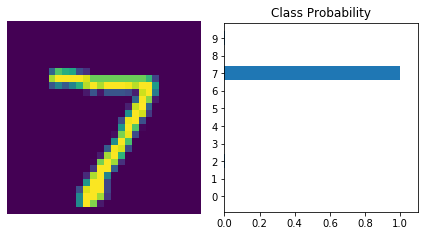

In [7]:
test_image, test_labels = testset[0] #next(iter(testloader))
test_image = test_image.view(1,28,28)
flatten_test_image = test_image.view(1,input_size)

with torch.no_grad():
    log_softmax = model(flatten_test_image)

probs = torch.exp(log_softmax)
helper.view_classify(test_image, probs, version='MNIST')

# Accuracy

In [8]:
correct = 0
for i in range(len(testset)):
    image, label = testset[i] # Test image and label
    flat_image = image.view(1, input_size) # Flatten image
    with torch.no_grad():
        log_softmax = model(flat_image) # Predicted 
    label_probs = torch.exp(log_softmax)
    label_pred = torch.argmax(label_probs)
    if int(label_pred) == label:
        correct += 1
print('Test accuracy: {}%'.format(100 * correct / len(testset)))

Test accuracy: 96.28%
